In [31]:
# importiamo le librerie che andremo ad utilizzare
import torch
import torchvision
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms, models
from torch.utils.data import random_split, DataLoader, Subset, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim
from collections import Counter
import time

In [32]:
# definisco le trasformazioni per i dati di input, sia il redimensionamento delle immagini che la conversione
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

# scarico il dataset per il train e per il test, se esiste già non viene scaricato
dataset = OxfordIIITPet(
    root="./data",
    split="trainval",
    target_types="category",
    transform=transform,
    download=True,
)
test_dataset = OxfordIIITPet(
    root="./data",
    split="test",
    target_types="category",
    transform=transform,
    download=True,
)

# Calcolare le dimensioni di training, validation e test
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

# Suddividere il dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

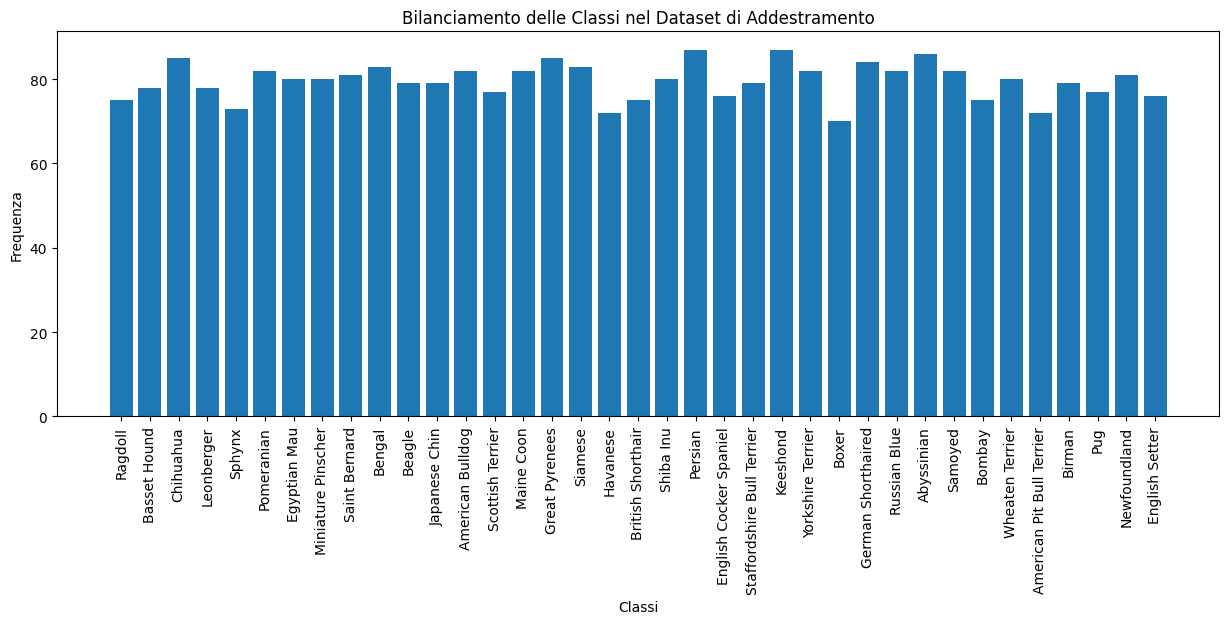

Conti delle classi: {'Ragdoll': 75, 'Basset Hound': 78, 'Chihuahua': 85, 'Leonberger': 78, 'Sphynx': 73, 'Pomeranian': 82, 'Egyptian Mau': 80, 'Miniature Pinscher': 80, 'Saint Bernard': 81, 'Bengal': 83, 'Beagle': 79, 'Japanese Chin': 79, 'American Bulldog': 82, 'Scottish Terrier': 77, 'Maine Coon': 82, 'Great Pyrenees': 85, 'Siamese': 83, 'Havanese': 72, 'British Shorthair': 75, 'Shiba Inu': 80, 'Persian': 87, 'English Cocker Spaniel': 76, 'Staffordshire Bull Terrier': 79, 'Keeshond': 87, 'Yorkshire Terrier': 82, 'Boxer': 70, 'German Shorthaired': 84, 'Russian Blue': 82, 'Abyssinian': 86, 'Samoyed': 82, 'Bombay': 75, 'Wheaten Terrier': 80, 'American Pit Bull Terrier': 72, 'Birman': 79, 'Pug': 77, 'Newfoundland': 81, 'English Setter': 76}


In [33]:
# Ottenere tutte le etichette di addestramento
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]

# Contare la frequenza di ciascuna classe
class_counts = Counter(train_labels)

# Ottenere i nomi delle classi
class_names = [dataset.classes[i] for i in class_counts.keys()]

# Visualizzare il bilanciamento delle classi
classes, counts = zip(*class_counts.items())
plt.figure(figsize=(15, 5))
plt.bar(class_names, counts)
plt.xlabel("Classi")
plt.ylabel("Frequenza")
plt.title("Bilanciamento delle Classi nel Dataset di Addestramento")
plt.xticks(rotation=90)  # Ruotare le etichette dell'asse X per una migliore leggibilità
plt.show()

# Stampare i conti delle classi
print("Conti delle classi:", dict(zip(class_names, counts)))

In [34]:
# Numero di esempi di addestramento, validation e test
num_train_samples = len(train_dataset)
num_val_samples = len(val_dataset)
num_test_samples = len(test_dataset)

print(f"Numero di esempi di addestramento: {num_train_samples}")
print(f"Numero di esempi di validation: {num_val_samples}")
print(f"Numero di esempi di test: {num_test_samples}")

Numero di esempi di addestramento: 2944
Numero di esempi di validation: 736
Numero di esempi di test: 3669


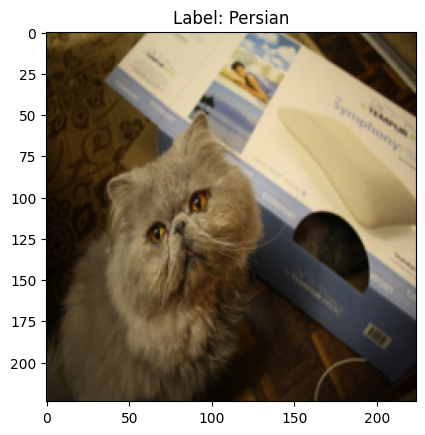

In [60]:
# Visualizzare un esempio del dataset
random_index = random.randint(0, len(train_dataset) - 1)  # Scegliere un indice casuale
example_img, example_label = train_dataset[random_index]  # Ottenere l'immagine e l'etichetta corrispondenti
plt.imshow(example_img.permute(1, 2, 0))
plt.title(f"Label: {dataset.classes[example_label]}")
plt.show()

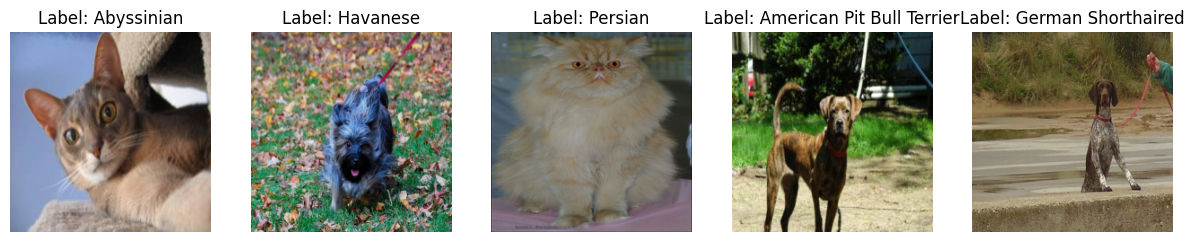

In [66]:
# Visualizzare alcune immagini di razze di cani/gatti random con etichette
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    random_index = random.randint(0, len(train_dataset) - 1)  # Scegliere un indice casuale
    img, label = train_dataset[random_index]  # Ottenere l'immagine e l'etichetta corrispondenti
    class_name = dataset.classes[label]  # Ottenere il nome della classe corrispondente all'etichetta
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f"Label: {class_name}")  # Mostrare il nome della classe anziché l'etichetta numerica
    axes[i].axis("off")
plt.show()

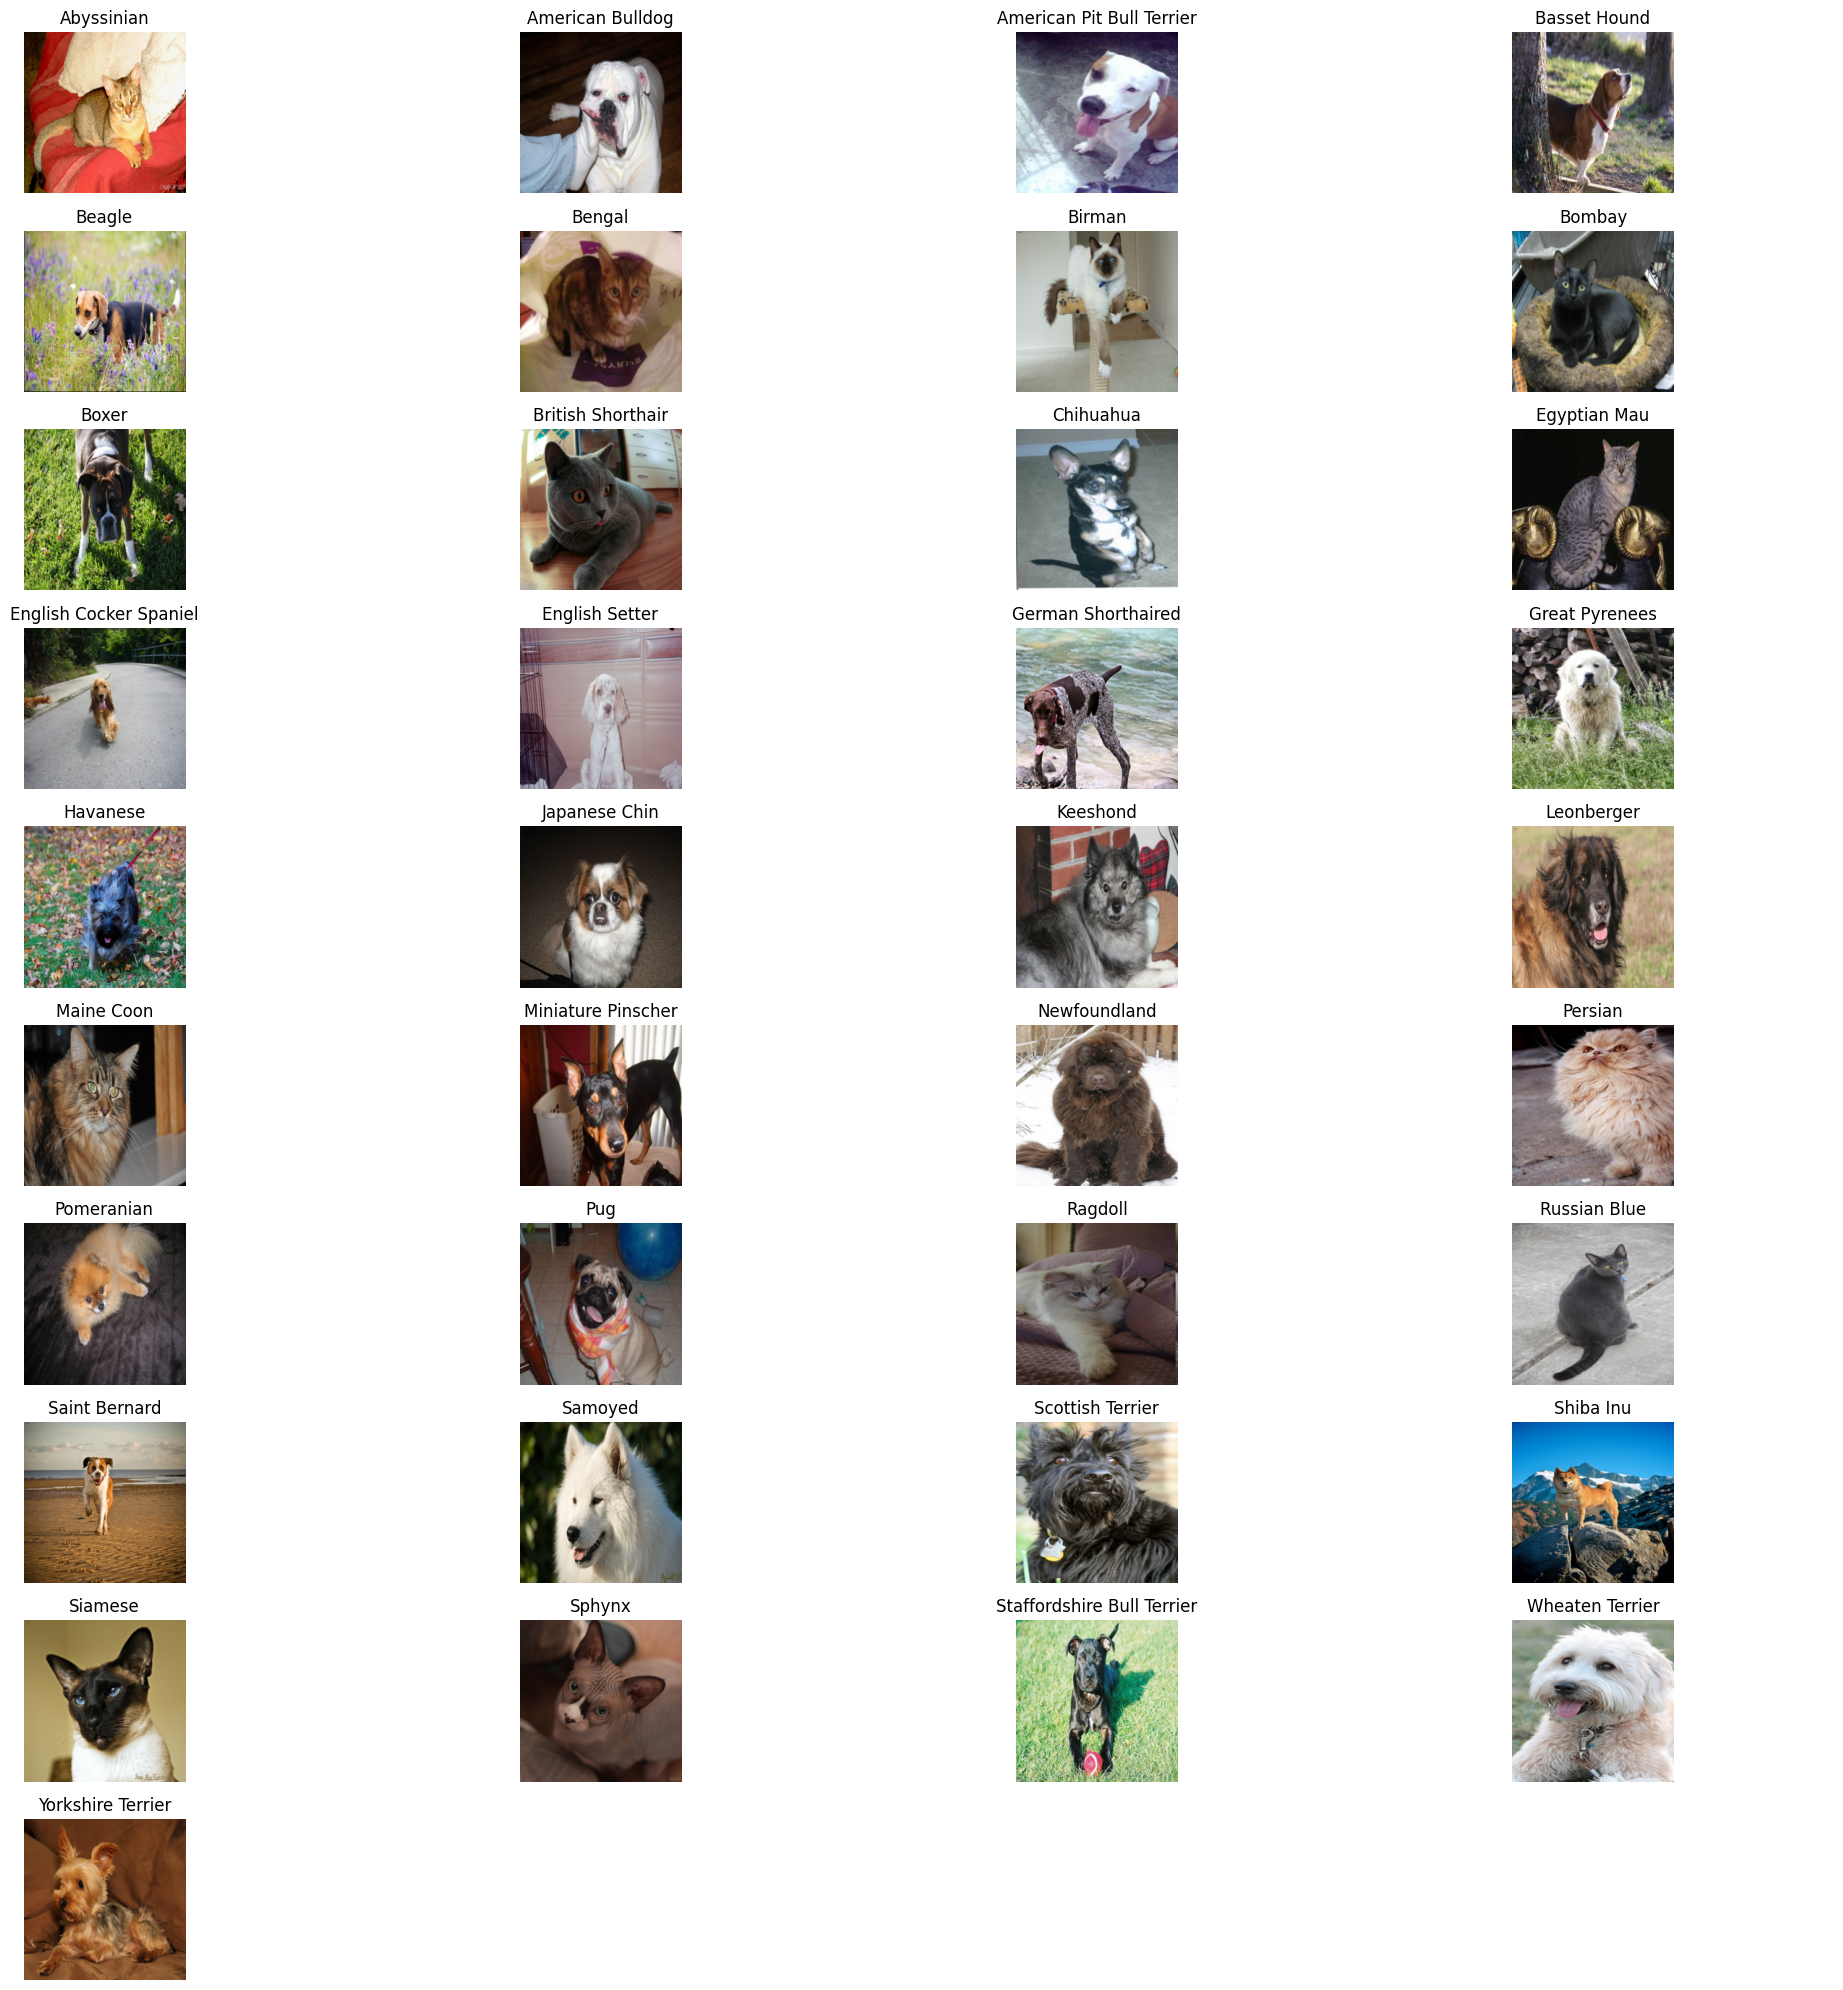

In [46]:
# Creare un dizionario per tenere traccia delle immagini casuali per ogni razza
random_images = {}

# Ottenere l'indice delle classi nel dataset
class_indices = {class_name: i for i, class_name in enumerate(dataset.classes)}

# Ottenere una foto random per ogni razza
for class_name in dataset.classes:
    indices = [
        i for i, label in enumerate(train_labels) if label == class_indices[class_name]
    ]
    random_index = random.choice(indices)
    random_images[class_name] = train_dataset[random_index][0]

# Determinare il numero di subplot necessari in base al numero di classi
num_classes = len(dataset.classes)
num_cols = 4
num_rows = (num_classes // num_cols) + 1  # Calcolare il numero di righe necessarie

# Visualizzare le immagini random per ogni razza
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.ravel()

for i, (class_name, img) in enumerate(random_images.items()):
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(class_name)
    axes[i].axis("off")

# Nascondere gli assi dei subplot non utilizzati
for j in range(len(random_images), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [38]:
# Calcolare la media e la deviazione standard dei pixel per il dataset di addestramento
loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
mean = 0.0
std = 0.0
n_samples = 0

for images, _ in loader:
    batch_samples = images.size(0)  # numero di immagini nel batch
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    n_samples += batch_samples

mean /= n_samples
std /= n_samples

print(f"Media dei pixel: {mean}")
print(f"Deviazione standard dei pixel: {std}")

Media dei pixel: tensor([0.4788, 0.4460, 0.3955])
Deviazione standard dei pixel: tensor([0.2259, 0.2229, 0.2243])
